In [2]:
'''Import Necessary Packages'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
import librosa
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T

print(torch.__version__)
print(torchaudio.__version__)

import librosa
import matplotlib.pyplot as plt
from PIL import Image

2.1.0+cu118
2.1.0+cu118


In [3]:
'''some pre-defined parameters'''
sample_rate: int = 44100
step_size_ms: int = 10
window_duration_ms: int = 100
padded_duration_ms: int = 400

# Mel scale parameters
num_frequencies: int = 512
min_frequency: int = 0
max_frequency: int = 10000
mel_scale_norm = None
mel_scale_type: str = "htk"
max_mel_iters: int = 200

# Griffin Lim parameters
num_griffin_lim_iters: int = 32

# Image parameterization
power_for_image: float = 0.25

n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
print('n_fft',n_fft)
win_length = int(window_duration_ms / 1000.0 * sample_rate)
print('win_length',win_length)
hop_length = int(step_size_ms / 1000.0 * sample_rate)  #426
print('hop_length',hop_length)

n_fft 17640
win_length 4410
hop_length 441


#Util Functions for Conversion

In [4]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=num_frequencies,
    sample_rate=sample_rate,
    f_min=min_frequency,
    f_max=max_frequency,
    n_stft=n_fft // 2 + 1,
    norm=mel_scale_norm,
    mel_scale=mel_scale_type,
)
spectrogram_func = torchaudio.transforms.Spectrogram(
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    pad=0,
    window_fn=torch.hann_window,
    power=None,
    normalized=False,
    wkwargs=None,
    center=True,
    pad_mode="reflect",
    onesided=True,
)
inverse_mel_scaler = torchaudio.transforms.InverseMelScale(
    n_stft=n_fft // 2 + 1,
    n_mels=num_frequencies,
    sample_rate=sample_rate,
    f_min=min_frequency,
    f_max=max_frequency,
    norm=mel_scale_norm,
    mel_scale=mel_scale_type,
)
inverse_spectrogram_func = torchaudio.transforms.GriffinLim(
    n_fft=n_fft,
    n_iter=num_griffin_lim_iters,
    win_length=win_length,
    hop_length=hop_length,
    window_fn=torch.hann_window,
    power=1.0,
    wkwargs=None,
    momentum=0.99,
    length=None,
    rand_init=True,
)

#Convert Audio File to Spectrogram Image

In [5]:
waveform, sample_rate = torchaudio.load('/content/MIDI-Unprocessed_01_R1_2006_01-09_ORIG_MID--AUDIO_01_R1_2006_02_Track02_wav.mp3')
cut=sample_rate*6
print(cut)
waveform = waveform[:,:cut]
print(waveform,waveform.shape)
print(sample_rate)

264600
tensor([[-0.0019, -0.0026, -0.0024,  ..., -0.1446, -0.1496, -0.1526],
        [-0.0007, -0.0010, -0.0007,  ..., -0.1513, -0.1519, -0.1516]]) torch.Size([2, 264600])
44100


In [6]:
def image_from_spectrogram(spectrogram,power):
  '''This function converts a mel spectrogram representation to an image'''
  spectrogram=np.array(spectrogram)
  # print(spectrogram.shape)
  spectrogram=spectrogram[:,:,:512]
  # print(spectrogram.shape)

  max_value=np.max(spectrogram)
  # print(max_value)

  data=spectrogram/max_value

  data=np.power(data, power)

  data=data*255
  # data=255-data
  data=data.astype(np.uint8)

  if data.shape[0] == 1:
    print('Single Channel Audio')
    image = Image.fromarray(data[0], mode="L").convert("RGB")
  else:
    data = np.array([np.zeros_like(data[0]), data[0], data[1]]).transpose(1, 2, 0)
    image = Image.fromarray(data, mode="RGB")

  image = image.transpose(Image.Transpose.FLIP_TOP_BOTTOM)
  return image,max_value

In [7]:
spectrogram_complex=spectrogram_func(waveform)
amplitudes = torch.abs(spectrogram_complex)
melspec = mel_scaler(amplitudes)
print(melspec.shape)

torch.Size([2, 512, 601])


(512, 512)
RGB
('R', 'G', 'B')
1148.6707


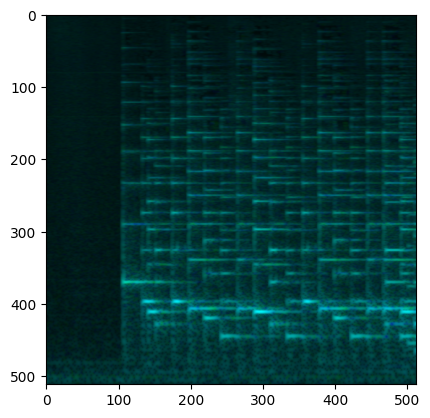

In [8]:
power=0.25
im,max_val=image_from_spectrogram(melspec,0.25)
#show image shape
print(im.size)
#check if image is in RGB
print(im.mode),print(im.getbands())
#check max value
print(max_val)

plt.imshow(im)
plt.show()

In [9]:
#save the image
im.save('/content/test_last.png')

#Convert Spectrogram Image to Audio File

In [10]:
path="/content/test_last.png"
im=Image.open(path)

In [11]:
def spectrogram_from_image(image: Image.Image,power: float = 0.25,stereo: bool = False,max_value: float = 30e6):
  '''This function converts an image to a spectrogram representation which is later used for generating the audio output'''
  if image.mode in ("P", "L"):
      image = image.convert("RGB")

  image = image.transpose(Image.Transpose.FLIP_TOP_BOTTOM)

  data = np.array(image).transpose(2, 0, 1)

  # data = np.array(image)
  data = data[[1, 2], :, :]

  data = data.astype(np.float32)
  data = data / 255
  data = np.power(data, 1 / power)
  data = data * max_value

  return data

In [12]:
# convert image to spectrogram
spectogram_recovered=spectrogram_from_image(im,power=0.25,max_value=max_val)
print(spectogram_recovered.shape)
print(spectogram_recovered.min(),spectogram_recovered.max())

(2, 512, 512)
0.001782399 1148.6707


In [13]:
#inverse spectogram to waveform
amplitudes_mel = torch.from_numpy(spectogram_recovered)

amplitudes_linear = inverse_mel_scaler(amplitudes_mel)
print(amplitudes_linear.shape)
inv_waveform=inverse_spectrogram_func(amplitudes_linear)
print(inv_waveform.shape)

torch.Size([2, 8821, 512])
torch.Size([2, 225351])


In [14]:
#normalize waveform and save to .wav file
samples=inv_waveform.numpy()

samples *= np.iinfo(np.int16).max / np.max(np.abs(samples))

samples = samples.transpose(1, 0)
samples = samples.astype(np.int16)

from scipy.io.wavfile import write
wavfile.write('/content/wav1.wav', sample_rate, samples)